In [4]:
import numpy as np
import gcsfs
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import intake
import xesmf as xe
%matplotlib inline
import cartopy
from cartopy import util
import cartopy.crs as ccrs
import zarr
import dask.array as da  
from dask.diagnostics import ProgressBar
from tqdm.autonotebook import tqdm
import nc_time_axis
import time

import cmip6_preprocessing
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [5]:
#cat_url = "/space/hall4/sitestore/eccc/crd/CMIP6/final/canesm_final.json"
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [6]:
# Fix some inconsistencies across datasets like dimension names, bounds, extra variables, etc.
from cmip6_preprocessing.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon, rename_cmip6

def wrapper(ds):
    ds = ds.copy()
    #ds = rename_cmip6(ds)
    #ds = replace_x_y_nominal_lat_lon(ds)
    
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height')
    return ds

In [25]:
dset_dicts={}
experiment_ids=['historical', 'ssp119','ssp126', 'ssp245', 'ssp370', 'ssp585']

for exp in experiment_ids:
    query = dict(table_id=['Amon'], 
                 variable_id=['tas'],
              experiment_id=exp, member_id='r1i1p1f1')
    cat = col.search(**query)
    dset_dicts[exp] = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                        storage_options={'token': 'anon'}, 
                                        preprocess=wrapper,)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 34 group(s)
[########################################] | 100% Completed |  2.2s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 7 group(s)
[########################################] | 100% Completed |  0.5s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 23 group(s)
[########################################] | 100% Completed |  1.3s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 22 gr

In [37]:
experiment_ids=['historical', 'ssp119','ssp126', 'ssp245', 'ssp370', 'ssp585']
dset_dicts_proc = {}

for exp in experiment_ids:
    tmp = {}
    for name, data in dset_dicts[exp].items():
        model = name.split('.')[2]
        tmp[model] = data
    dset_dicts_proc[exp] = tmp

dset_dicts_match['historical'] = dset_dicts_proc['historical']
    
experiment_ids=['ssp119','ssp126', 'ssp245', 'ssp370', 'ssp585']
for exp in experiment_ids:
    tmp = {}
    for name, data in dset_dicts_proc[exp].items():
        if name in dset_dicts_proc['historical'].keys(): 
            tmp[name] = data
    dset_dicts_match[exp] = tmp                  

In [39]:
gmst_dicts = {}
#glob_area = areacella.sum(dim=['lon', 'lat'])
for exp, dic in dset_dicts_match.items():
    tmp = {}
    for model, data in dic.items():
        cos_lat_2d = np.cos(np.deg2rad(data['lat'])) * xr.ones_like(data['lon'])
        tmp[model] = ((data * cos_lat_2d).sum(dim=['lon', 'lat'])/cos_lat_2d.sum(dim=['lat','lon'])).compute()
    gmst_dicts[exp] = tmp    

In [48]:
gmst_anom_dicts = {}
#glob_area = areacella.sum(dim=['lon', 'lat'])
for exp, dic in gmst_dicts.items():
    tmp = {}
    for model, data in dic.items():
        try:
            tmp[model] = (data.sel(time=slice('1850','2100')) - 
                          gmst_dicts['historical'][model].sel(time=slice('1850','1900')).mean(dim='time')
                         ).groupby('time.year').mean(dim='time').compute()
        except:
            print('Failed:', model)
    gmst_anom_dicts[exp] = tmp   

Failed: MPI-ESM1-2-HR
Failed: NorESM2-MM
Failed: MPI-ESM1-2-HR
Failed: MPI-ESM1-2-HR
Failed: MPI-ESM1-2-HR
Failed: MPI-ESM1-2-HR


In [58]:
gmst_anoms = {}
#glob_area = areacella.sum(dim=['lon', 'lat'])
for exp, dic in gmst_anom_dicts.items():
    dss = [ds for key, ds in dic.items()]
    gmst_anoms[exp] = xr.concat(dss, dim='source_id')

In [75]:
# Download obs from my FTP.
! wget ftp://crd-data-donnees-rdc.ec.gc.ca/pub/CCCMA/nswart/fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc

--2020-04-28 01:11:24--  ftp://crd-data-donnees-rdc.ec.gc.ca/pub/CCCMA/nswart/fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc
           => ‘fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc’
Resolving crd-data-donnees-rdc.ec.gc.ca (crd-data-donnees-rdc.ec.gc.ca)... 205.189.10.93
Connecting to crd-data-donnees-rdc.ec.gc.ca (crd-data-donnees-rdc.ec.gc.ca)|205.189.10.93|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/CCCMA/nswart ... done.
==> SIZE fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc ... 48384
==> PASV ... done.    ==> RETR fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc ... done.
Length: 48384 (47K) (unauthoritative)

fldmean_NASA-GISS_g 100%[===================>]  47.25K  --.-KB/s    in 0.1s    

2020-04-28 01:11:25 (325 KB/s) - ‘fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc’ saved [48384]



In [61]:
obs = xr.open_dataset('fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc')

In [62]:
obs_anom = (obs - obs.sel(time=slice('1850','1900')).mean(dim='time')).groupby('time.year').mean(dim='time')

In [70]:
upper_bounds = {}
lower_bounds = {}
for key, data in gmst_anoms.items():
    upper_bounds[key] = (data['tas'].mean(dim='source_id') + 
                         data['tas'].std(dim='source_id')*2.0).squeeze()#/np.sqrt(len(data['tas'].member_id)))
    lower_bounds[key] = (data['tas'].mean(dim='source_id') -
                         data['tas'].std(dim='source_id')*2.0).squeeze()#/np.sqrt(len(data['tas'].member_id))) 

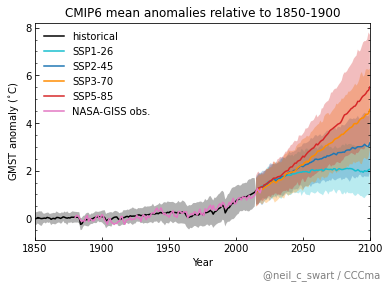

In [87]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

colors = ['k', 'tab:cyan', 'tab:blue', 'darkorange', 'tab:red']
label = ['historical', 'SSP1-26', 'SSP2-45', 'SSP3-70', 'SSP5-85']
for i, key in enumerate(['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']):
    ax.fill_between(gmst_anoms[key].year, upper_bounds[key], lower_bounds[key], 
                    facecolor=colors[i], alpha=0.3)

    ax.plot(gmst_anoms[key].year, gmst_anoms[key]['tas'].mean(dim='source_id'), 
            color=colors[i], label=label[i])
    
ax.plot(obs_anom.year, obs_anom.tempanomaly.squeeze(), 'tab:pink', label='NASA-GISS obs.')
ax.legend(frameon=False, loc='upper left')
ax.set_ylabel('GMST anomaly ($^{\circ}$C)')
ax.set_xlabel('Year')
ax.set_xlim([1850, 2100])
ax.text(2020,-2.5, '@neil_c_swart / CCCma', alpha=0.5)

ax.set_title('CMIP6 mean anomalies relative to 1850-1900')
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='both', left=True, right=True, which='both', direction='in')
fig.savefig('CMIP6_GMST_anomalies_plus-obs.png', bbox_inches='tight', dpi=300)